insights (embeddinggemma-300m-haystack-contrastive-thin-fixed):

County relations should be investigated, because train dataset contains only 'Collier'

* H0: the embedding space changed not only 'Collier' but all counties as a concept

* H1: the model was overfitted on 1 exact county


H0 was tested on only 1 example with 'Dallas' county and showed that H0 is might be true.

* H0: model checks only for the corresponding presence of county, it doesn't care if county remains the same

* H1: model checks whether the county remains the same


H0 was also tested on only 1 example of changing county in output_text from 'Collier' to 'Dallas'. It seems that it's might be false and model cares whether the county remains the same. The problem is, distribution on angles slightly differs, so model still has to see different counties (at least 2) in training set!-> H1

The cool thing about gemma is brand-new Matryoshka architecture inside. We can utilize just fraction of a model and embedding dimensions to process text with almost the same results.

The finetuned model still has Matryoshka properties even without additional matryoshka loss during training.

ML Notes:
* It's possible to make model more stable and increase excess of cosine distribution a little with paying the price of maximum performance
* Should consider optimize Matryoshka with different losses in hierarchical embeddings, maybe it could lead to better utilization of classification head
* Definitely to add different names of counties in dataset. It's wonderful that model has already figured out the rules on its own, but reinforcement won't bother

Recreating train_test sets

In [1]:
from datasets import load_dataset
import numpy as np
raw_ds = load_dataset('json', data_files='../training_dataset/final_dataset/dataset.jsonl')
def process_input(example):
    example["input_text"] += f'section: {example["section"]},\ncounty: {example["county"]},\nparcel_id: {example["parcel_id"]}'
    #example["output_text"] = re.sub(r"county.*?\n", "", example["output_text"])
    return example

def process_ds(dataset):
    #dataset = dataset.select_columns(['input_text', 'output_text', 'output_empty', 'label'])
    #dataset = dataset.filter(lambda example: example["output_empty"] == False)
    dataset = dataset.map(process_input)
    dataset = dataset.select_columns(['section', 'input_text', 'output_text', 'label'])

    return dataset

cos_ds = process_ds(raw_ds["train"])

#train_test_split without data leakage
from sklearn.model_selection import train_test_split
from datasets import DatasetDict
ids = np.arange(len(cos_ds))[:-1:2]
train_id, test_id = train_test_split(
    ids,
    train_size=0.8,
    random_state=42
)

rng = np.random.default_rng(seed = 42)
train_id_adj = train_id + 1
train_id = np.append(train_id, train_id_adj)
rng.shuffle(train_id)
test_id_adj = test_id + 1
test_id  = np.append(test_id, test_id_adj)
rng.shuffle(test_id)
cos_alt_ds = DatasetDict({
    "train": cos_ds.select(train_id),
    "test": cos_ds.select(test_id)
})
cos_ds = cos_alt_ds
cos_eval = cos_ds["test"]
#

# cos_ds = cos_ds.train_test_split(test_size=0.2, seed = 42) #possible data leakage
# cos_eval = cos_ds["test"]
print(np.any(np.isin(train_id, test_id)))
np.sort(test_id)[:7]

False


array([ 4,  5, 14, 15, 20, 21, 46])

In [10]:
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import itertools
class DeepClassifier(nn.Module):
    def __init__(self, feature_in):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=feature_in, out_features=768*2, bias = False), #-4 because conv kernel3 twice
            nn.Softplus(),
            # nn.Linear(in_features=768*2, out_features=768*2, bias = False),
            # nn.Softplus(),
            nn.Linear(in_features=768*2, out_features=768, bias = False),
            nn.Softplus(),
            nn.Linear(in_features=768, out_features=1, bias = False),
            nn.Sigmoid()
        )

    def train_model(self,
                    train_feature_tensor:torch.Tensor,
                    train_label_tensor:torch.Tensor,
                    test_feature_tensor:torch.Tensor,
                    test_label_tensor:torch.Tensor,
                    batch_size:int,
                    train_steps:int,
                    eval_schedule:int):

        eval_steps = test_label_tensor.shape[0] // batch_size
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001) #maybe muon
        loss = nn.MSELoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        cum_loss = 0

        train_dataset = TensorDataset(train_feature_tensor, train_label_tensor)
        train_loader = itertools.cycle(DataLoader(train_dataset, batch_size=batch_size))

        for step in range(train_steps):
            optimizer.zero_grad()
            #train_batch = train_feature_tensor[ batch_size*step : batch_size*(step+1)].to(device)
            #train_label = train_label_tensor[ batch_size*step : batch_size*(step+1)].to(device)
            train_batch, train_label= next(train_loader)
            train_batch =  train_batch.to(device)
            train_label =  train_label.to(device)
            prediction = torch.squeeze(self.model(train_batch))

            los = loss(prediction, train_label)
            cum_loss += los.item()
            los.backward()
            optimizer.step()

            if step % eval_schedule == 0:
                total_loss = 0
                for eval_step in range(eval_steps):
                    with torch.no_grad():
                        eval_batch = test_feature_tensor[ batch_size*eval_step : batch_size*(eval_step+1)].to(device)
                        eval_label = test_label_tensor[ batch_size*eval_step : batch_size*(eval_step+1)].to(device)
                        prediction = torch.squeeze(self.model(eval_batch))

                        total_loss += loss(prediction, eval_label).item()
                print(f"step: {step}\ntrain avg loss on batch: {cum_loss/eval_steps}\neval avg loss on batch: {total_loss/eval_steps}")
                cum_loss = 0

    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with torch.no_grad():
            x = x.to(device)
            return self.model(x.to(device)).cpu().detach().numpy()

    def predict_proba(self, x):
        return self.model(x)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, PrecisionRecallDisplay
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import transformers

class HugeReporter:
    def __init__(self, model, train_set, test_set):
        #evaluated model
        self.model = model
        #corpus of text, with embed_set -> corpus of embeddings (dict)
        self.train_set = train_set
        self.test_set = test_set
        #pd dataframes with distances
        self._stat_df = None
        self._eval_df = None

        self.sections = None
        self._classification_module = None
        self._distances = ["l1_dist", "l2_dist", "l_inf_dist", "cos_dist", "inf_1_ratio", "inf_2_ratio", "inf_cos_ratio"]
        self._embedding_sizes = [128, 256, 512, 768]

    @staticmethod
    def embedding_generator(dataset, prompt_use = "STS"):
        """
        embed train and test sets info train_set and test_set vars
        """
        embedding_dict = {}
        for col in ['input_text', 'output_text']:
            embeddings = model.encode(dataset[col],
                                            prompt_name=prompt_use,
                                            #show_progress_bar = False,
                                            convert_to_numpy = False,
                                            batch_size = 4
                                           )

            embedding_dict[col] = torch.stack(embeddings)
            embedding_dict["label"] = dataset["label"]
            embedding_dict["section"] = dataset["section"]
        return embedding_dict

    @staticmethod
    def statistic(batch, embed_size:int = 768, drop_embeds:bool = True):
        """
        calculate embedding distances in different space distances in different spaces
        """
        #(128, 256, 512, 768) - matryoshka sizes
        l_dif = batch['input_text'][:, :embed_size] - batch['output_text'][:, :embed_size]

        l1_dist = torch.linalg.norm(l_dif, ord =1, dim = 1)
        l2_dist = torch.linalg.norm(l_dif, ord =2, dim = 1)
        l_inf_dist = torch.linalg.norm(l_dif, ord = torch.inf, dim = 1)
        cos_estimator = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
        cos_dist = 1 - cos_estimator(batch['input_text'], batch['output_text'])

        if drop_embeds:
            batch.pop('input_text')
            batch.pop('output_text')

        batch[f'l1_dist_{embed_size}'] = l1_dist.cpu().detach().numpy()
        batch[f'l2_dist_{embed_size}'] = l2_dist.cpu().detach().numpy()
        batch[f'l_inf_dist_{embed_size}'] = l_inf_dist.cpu().detach().numpy()
        batch[f'cos_dist_{embed_size}'] = cos_dist.cpu().detach().numpy()
        batch[f'inf_1_ratio_{embed_size}'] = batch[f'l_inf_dist_{embed_size}'] / batch[f'l1_dist_{embed_size}']
        batch[f'inf_2_ratio_{embed_size}'] = batch[f'l_inf_dist_{embed_size}'] / batch[f'l2_dist_{embed_size}']
        batch[f'inf_cos_ratio_{embed_size}'] = batch[f'l_inf_dist_{embed_size}'] / batch[f'cos_dist_{embed_size}']

        return batch #input_text, output_text, distances, label

    def embed_set(self):
        """
        embed train and test sets info train_set and test_set vars
        """
        self.train_set = self.embedding_generator(self.train_set)
        self.test_set = self.embedding_generator(self.test_set)

    def embed_distances(self, embed_sizes:list[int]|None = None):
        """
        calculate embedding distances in different space distances in different spaces
        """
        if embed_sizes is None:
            embed_sizes = self._embedding_sizes

        for embed_size in embed_sizes:
            #train
            stat_ds = self.statistic(self.train_set.copy(), embed_size = embed_size)
            if self._stat_df is None:
                self._stat_df = pd.DataFrame.from_dict(stat_ds)
            else:
                self._stat_df = pd.concat((self._stat_df, pd.DataFrame.from_dict(stat_ds).drop(columns = ['label', 'section'])), axis = 1)
            #test
            stat_ds = self.statistic(self.test_set.copy(), embed_size = embed_size)
            if self._eval_df is None:
                self._eval_df = pd.DataFrame.from_dict(stat_ds)
            else:
                self._eval_df = pd.concat((self._eval_df, pd.DataFrame.from_dict(stat_ds).drop(columns = ['label', 'section'])), axis = 1)

        self.sections = self._stat_df["section"].unique()

    def plot_pairplots(self, set_type:str, sections:list[str]|None|str = None, embed_sizes:list[int]|None =None):
        """
        plots distance paired distributions for selected set(str) ('train' / 'test'); sections(list(str from section type) | 'All' takes all possible); embedding size(list[0 < int <= 768])
        """
        if set_type == 'train':
            plot_df = self._stat_df
        elif set_type == 'test':
            plot_df = self._eval_df
        else:
            raise ValueError(f'set_type must be "train" or "test"')

        if embed_sizes is None:
            embed_sizes = [768]

        #in case, if user didn't calculate them before
        if plot_df is None:
            self.embed_distances(embed_sizes = embed_sizes)

        #if sections aren't provided not select any
        if sections == "All":
            sections = self.sections
        if sections is None:
            section_counter = 1
        else:
            section_counter = len(sections)

        for section_id in range(section_counter):
            #if sections aren't provided not select any
            if sections is not None:
                print(f"Section: {sections[section_id]}")
                to_plot_df = plot_df[plot_df['section'] == sections[section_id]]
            else:
                to_plot_df = plot_df

            for embed_size in embed_sizes:
                print(f'embedding size {embed_size}')
                sns.pairplot(
                    to_plot_df[
                        ["label"] +
                        list(
                            map(
                                lambda item:
                                item + f"_{embed_size}",
                                ["l1_dist", "l2_dist", "l_inf_dist", "cos_dist", "inf_1_ratio", "inf_2_ratio", "inf_cos_ratio"]))
                    ],
                    hue = 'label'
                )
                plt.show()

    def _train_model(self, model, train_set, test_set = None, steps = None, batch_size = None, eval_scheduler = None):
        if isinstance(model, LogisticRegression):
            train_X, train_y = train_set.drop(columns = ['label']), train_set['label']
            model.fit(train_X, train_y)


        elif isinstance(model, torch.nn.Module):
            train_X, train_y = train_set['features'], train_set['label']
            test_X, test_y = test_set['features'], test_set['label']
            model.train_model(
                train_X,
                train_y,
                test_X,
                test_y,
                batch_size,
                steps,
                eval_scheduler
            )

        else:
            raise ValueError
        return model

    def _evaluate_model(self, model, test_set):
        if isinstance(self._classification_module, LogisticRegression):
            test_X, test_y = test_set.drop(columns = ['label']), test_set['label']
            y_pred = model.predict_proba(test_X)[:, 1]
        elif isinstance(model, nn.Module):
            test_X, test_y = test_set['features'], test_set['label'].numpy()
            y_pred = model(test_X)
        elif model is None:
            y_pred, test_y = 1-test_set['cos_dist_768'], test_set['label']
        else:
            raise ValueError

        precision, recall, thresholds = precision_recall_curve(test_y, y_pred)
        roc_auc = roc_auc_score(test_y, y_pred)
        fpr, tpr, threshold = roc_curve(test_y, y_pred)

        sns.lineplot(x = fpr, y = tpr)
        plt.show()
        disp = PrecisionRecallDisplay(precision, recall)
        disp.plot()
        plt.show()

        print("roc_auc: ",roc_auc)

        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
        print(f"best f1: {np.max(f1_scores)}\nthreshold: {thresholds[np.argmax(f1_scores-1)]}")#id starts from 1, HAHAHAHAHAHAH

    def classification_model_report(self, type:str|None ='lr', steps:int|None = None, batch_size:int|None = None, eval_scheduler:int|None = None, sections:list[str]|None = None):
        """
        type defines the model, lr - LogisticRegression
        """

        if self._stat_df is None:
            self.embed_distances()

        #define classification model
        if type == 'lr':
            model = LogisticRegression()

        elif type == 'nn': #to change name
            model = DeepClassifier(self.train_set['input_text'][0].shape[0]*2 + len(self._distances) * len(self._embedding_sizes))
        elif type is None:
            model = None
        else:
            raise ValueError(f"type of model {type} isn't implemented")

        #if sections aren't provided don't select any
        if sections is None:
            section_counter = 1
        else:
            section_counter = len(sections)

        if isinstance(model, LogisticRegression) or model is None: # to change on generic sklearn class
            for section_id in range(section_counter):
                #if sections aren't provided don't select any
                if sections is not None:
                    print("Section: ", sections[section_id])
                    train_df = self._stat_df[self._stat_df['section'] == sections[section_id]].drop(columns = ['section'])
                    test_df = self._eval_df[self._eval_df['section'] == sections[section_id]].drop(columns = ['section'])
                else:
                    train_df = self._stat_df.drop(columns = ['section'])
                    test_df = self._eval_df.drop(columns = ['section'])

                if model is not None:
                    self._classification_module= self._train_model(model, train_df)
                else:
                    self._classification_module=None

                self._evaluate_model(self._classification_module, test_df)

        elif isinstance(model, nn.Module):
            #train tensor
            metrics_tensor = torch.Tensor(self._stat_df.drop(columns = ['label', 'section']).to_numpy())
            try:
                metrics_tensor = torch.cat((metrics_tensor, self.train_set['input_text'], self.train_set['output_text']), dim = 1)
            except:
                self.train_set['input_text'] = self.train_set['input_text'].cpu().detach()
                self.train_set['output_text'] = self.train_set['output_text'].cpu().detach()
                metrics_tensor = torch.cat((metrics_tensor, self.train_set['input_text'], self.train_set['output_text']), dim = 1)
            train_set = {"features": metrics_tensor,
                         "label": torch.tensor(self.train_set["label"][:], dtype=torch.float)
                         }
            #test tensor
            metrics_tensor = torch.Tensor(self._eval_df.drop(columns = ['label', 'section']).to_numpy())
            try:
                metrics_tensor = torch.cat((metrics_tensor, self.test_set['input_text'], self.test_set['output_text']), dim = 1)
            except:
                self.test_set['input_text'] = self.test_set['input_text'].cpu().detach()
                self.test_set['output_text'] = self.test_set['output_text'].cpu().detach()
                metrics_tensor = torch.cat((metrics_tensor, self.test_set['input_text'], self.test_set['output_text']), dim = 1)

            test_set = {"features": metrics_tensor,
                         "label": torch.tensor(self.test_set["label"][:], dtype=torch.float)
                         }

            self._classification_module=self._train_model(model, train_set, test_set, steps, batch_size, eval_scheduler)
            self._evaluate_model(self._classification_module, test_set)

        else:
            raise ValueError(f"type of model {type} isn't implemented in section selecting")


In [28]:
#micro test just in changing county:
import random
random.seed(42)

def country_change(example):
    counties_to_sample = ['Autauga', 'Cook', 'Harris', 'Maricopa', 'San Diego', 'Orange', 'Collier', 'Kings', 'Dallas']
    states_to_sample = ['AL', 'IL', 'TX', 'AZ', 'CA', 'CA', 'FL', 'NY', 'TX']
    #change county in each row
    idx = list(range(len(counties_to_sample)))
    sample_id = random.choice(idx)
    example["input_text"] = example["input_text"].replace("Collier", counties_to_sample[sample_id])
    example["input_text"] = example["input_text"].replace("FL", states_to_sample[sample_id])

    #change county in output
    if "Collier" in example["output_text"]:
        example["output_text"] = example["output_text"].replace("Collier", counties_to_sample[sample_id])
        example["output_text"] = example["output_text"].replace("FL", states_to_sample[sample_id])

        if example["label"] == 1:
            if random.choice([0, 1, 2]) == 1:

                random_counties = idx.copy()
                random_counties.remove(sample_id)

                example["output_text"] = example["output_text"].replace("Collier", counties_to_sample[random.choice(random_counties)])
                example["output_text"] = example["output_text"].replace("FL", states_to_sample[random.choice(idx)])


                example["label"] =0

    return example
cos_ds = cos_ds.map(country_change)

SOTA statistics

In [4]:
#define sota model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("mancer146/embeddinggemma-300m-haystack-contrastive-thin-fixed") #"google/embeddinggemma-300m"
#essential parameters: prompt = "STS"
prompt_use = "STS"
reporter = HugeReporter(model,
                        cos_ds["train"],
                        cos_ds["test"])
#essential parameters: prompt = "STS"

In [5]:
reporter.embed_set()

In [6]:
reporter.embed_distances()

In [ ]:
reporter.plot_pairplots(set_type= "test", sections = "All",embed_sizes=[768])

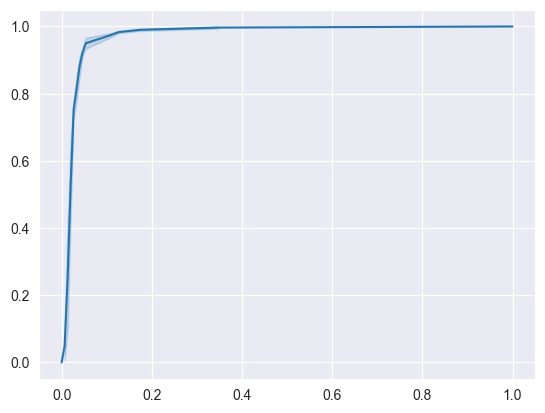

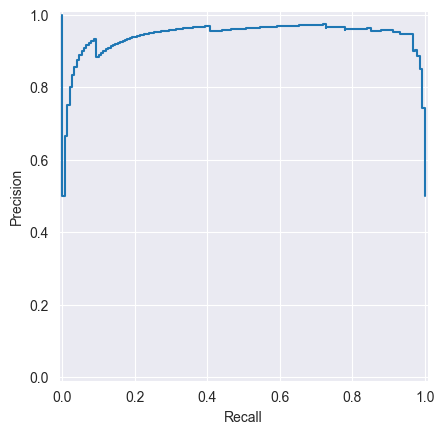

roc_auc:  0.9741555555555556
best f1: 0.9570956595758612
threshold: 0.9849652051925659


In [7]:
reporter.classification_model_report(type=None)

step: 0
train avg loss on batch: 0.06166841462254524
eval avg loss on batch: 0.27216555923223495
step: 150
train avg loss on batch: 1.5685450180171756
eval avg loss on batch: 0.059900492429733276
step: 300
train avg loss on batch: 0.746684777480823
eval avg loss on batch: 0.046107240952551365
step: 450
train avg loss on batch: 0.6560919483958969
eval avg loss on batch: 0.042589270044118166
step: 600
train avg loss on batch: 0.6160752159366893
eval avg loss on batch: 0.043823071755468845


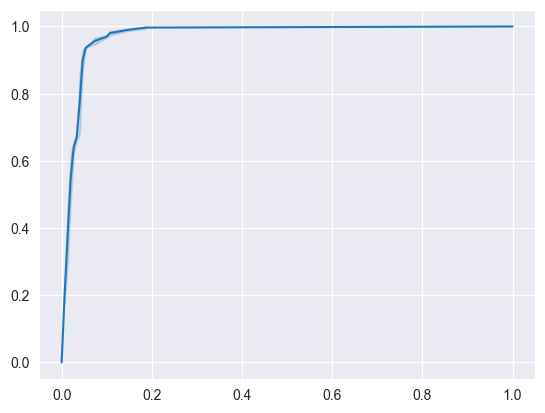

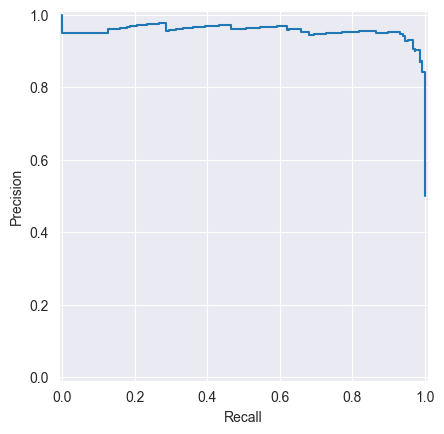

roc_auc:  0.9742444444444445
best f1: 0.9477123683198796
threshold: 0.4052361845970154


In [31]:
reporter.classification_model_report(type='nn', steps = 750, batch_size=64, eval_scheduler=150)#, sections = reporter.sections)

In [107]:
#define default model
from huggingface_hub import notebook_login
notebook_login()
model = SentenceTransformer("google/embeddinggemma-300m") #"google/embeddinggemma-300m"
#essential parameters: prompt = "STS"
prompt_use = "STS"
reporter = HugeReporter(model,
                        cos_ds["train"],
                        cos_ds["test"])

In [108]:
reporter.embed_set()

In [109]:
reporter.embed_distances()

In [ ]:
reporter.plot_pairplots(set_type= "test",
                        #sections= "All",
                        embed_sizes = [128,256, 512, 768])

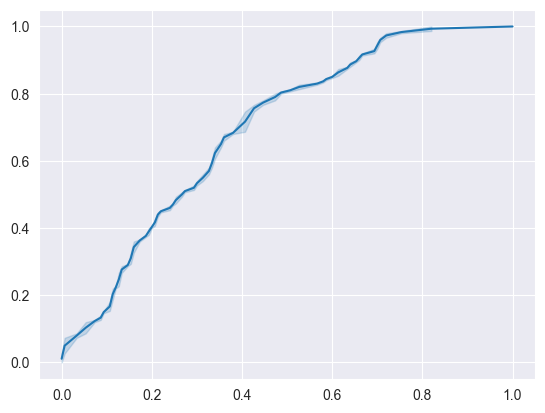

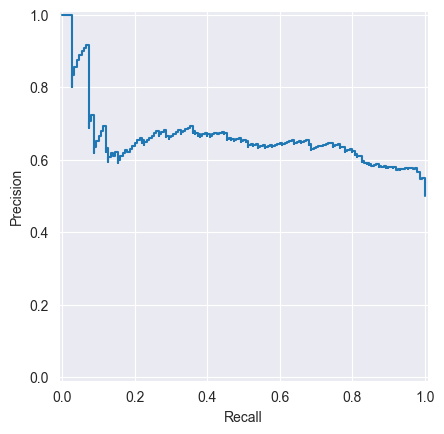

roc_auc:  0.6972222222222223


In [111]:
reporter.classification_model_report()